In [1]:
!pip install dtaidistance


     -------------------------------------- 854.6/854.6 kB 9.1 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, resample
from scipy.signal.windows import hamming

from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

import joblib as jb


c:\Users\maxim\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
ppgs = pd.read_csv("ppg_files.csv", header=None)
spo2 = pd.read_csv("spo2.csv", header=None)


In [3]:
ppgs.head()


,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,0.43597,0.63636,0.18866,0.67253,0.41642,0.30499,0.30303,0.63636,0.40274,0.36070,...,2.0362,1.9159,1.8162,2.1760,2.7449,0.30401,0.56500,0.59531,1.1848,1.3060
1,0.43206,0.65689,0.20137,0.69892,0.41153,0.30694,0.29814,0.61779,0.39785,0.35582,...,2.0811,1.9062,1.7771,2.1359,2.8524,0.29912,0.56891,0.57967,1.1642,1.2903
2,0.42815,0.67351,0.21994,0.72336,0.40665,0.30987,0.29326,0.59922,0.39394,0.35191,...,2.1202,1.8915,1.7419,2.0968,2.9130,0.29619,0.57185,0.56403,1.1466,1.2747
3,0.42424,0.68817,0.25220,0.74291,0.40078,0.31183,0.28837,0.57771,0.39101,0.34800,...,2.1525,1.8719,1.7107,2.0547,2.9267,0.29326,0.57380,0.54839,1.1349,1.2590
4,0.42131,0.69990,0.29717,0.75758,0.39492,0.31476,0.28446,0.55523,0.38710,0.34506,...,2.1818,1.8485,1.6872,2.0088,2.8974,0.29130,0.57380,0.53568,1.1339,1.2444


In [4]:
spo2.head()


,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,97.0,100,97,93,99.0,99,95,93,93,98,...,97.0,100,95,98,99,86,98,98,93,100
1,97.0,100,97,93,99.0,99,95,93,93,99,...,97.0,100,95,98,99,86,98,98,93,100
2,97.0,100,97,93,99.0,99,95,93,93,99,...,97.0,100,95,98,99,86,98,98,93,100
3,97.0,100,97,93,99.0,99,95,93,93,99,...,97.0,100,95,98,99,86,98,98,93,100
4,97.0,100,97,93,99.0,99,95,93,93,99,...,97.0,100,96,98,99,86,98,98,93,100


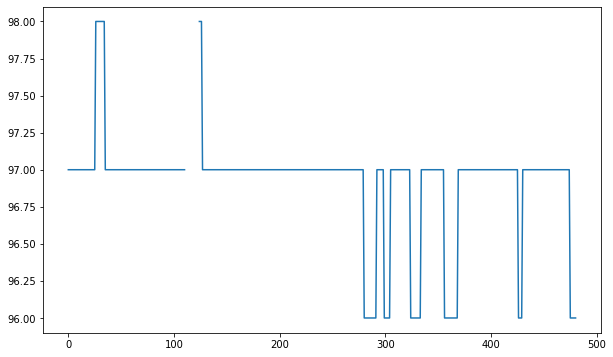

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(spo2[0])


_Here we can see that there are some missing measurements in between 100-200_

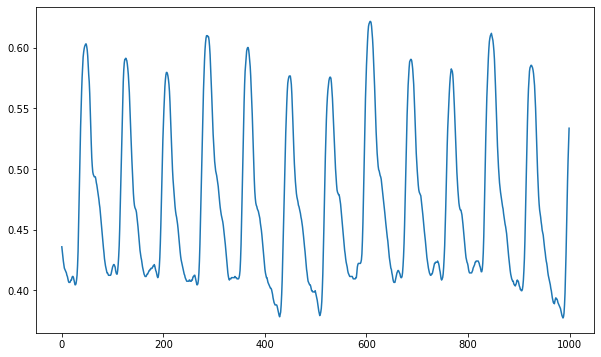

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(ppgs[0][0:125*8])


_Data needs to be windowed. I checked some papers and the window size that they have used was 8 seconds_

_The window that I have used above has a window size of 8_

**Since the data is so clear we might not need to Low-Pass filter the data. We can still filter it, but we have to check the spectrogram first**

In [7]:
ppg_subpart = ppgs[0][0:125*8]


In [8]:
f, t, Sxx = spectrogram(ppg_subpart, fs=125, nfft=256)


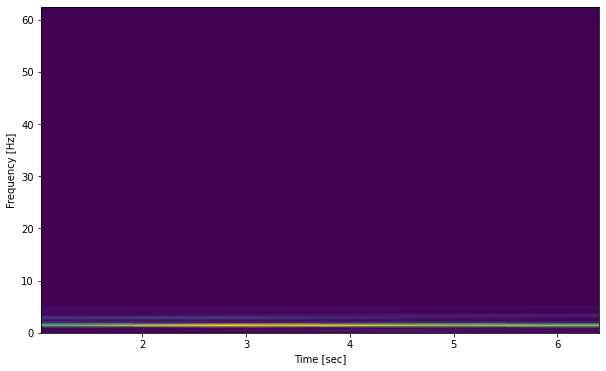

In [9]:
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


_It is already lowpass filtered_

# Downsampling Availibility Check

_First I will downsample the signal to 30Hz. So I will try whether it is good to resample the signal with 30Hz. So, I want to try considering DTW distance between the downsampled signal and the original signal to check whether they are good or not._

In [10]:
temp = ppgs[0][0:125*8]
temp1 = resample(temp, 30*8)
temp1_reupsampled = resample(temp1, 125*8)


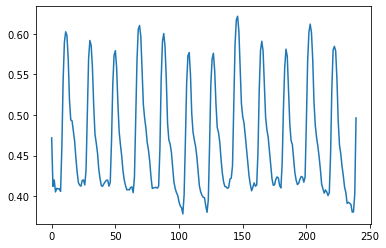

In [11]:
plt.plot(temp1)


In [12]:
distance = dtw.distance(temp, temp1)


In [13]:
distance


0.2675001131044622

(<Figure size 432x288 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

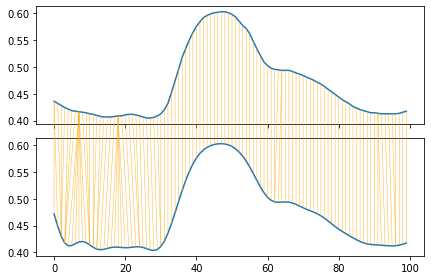

In [14]:
path = dtw.warping_path(temp[0:100], temp1_reupsampled[0:100])
dtwvis.plot_warping(temp[0:100], temp1_reupsampled[0:100], path)


_Here we can observe that they are nearly matching 1-1 mostly, that means there is no loss in downsampling the signal_

# Downsampling the signal 

In [15]:
temp_ppg = ppgs[0]
dsamp_ppgs = np.zeros((ppgs.shape[1], int(len(temp_ppg)*30/125)))
for i in range(ppgs.shape[1]):
    temp_ppg = ppgs[i]
    downsampled_ver = resample(temp_ppg, int(len(temp_ppg)*30/125))
    dsamp_ppgs[i] = downsampled_ver


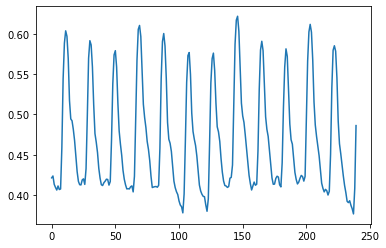

In [16]:
plt.plot(dsamp_ppgs[0][0:240])


# Windowing Based on Downsampled Signals

**Windowing Without Usage of the Stride**

In [17]:
window_length = 240
num_of_windows = int(14400/240)
window = hamming(240)

windowed_signals_no_stride = dict()

for i in range(ppgs.shape[1]):
    windows_for_session = dict()
    temp_ppg = dsamp_ppgs[i]
    for j in range(num_of_windows):
        selected_part = temp_ppg[j*240:(j+1)*240]
        windowed = selected_part*window
        windows_for_session[j] = windowed
    windowed_signals_no_stride[i] = windows_for_session


In [18]:
windowed_signals_no_stride.keys()


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52])

In [19]:
windows_for_session.keys()


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])

**Windowing With Usage of the Stride**

In [20]:
window_length = 240
num_of_windows = int(14400/60)
window = hamming(240)
stride = 2

windowed_signals_stride = dict()

for i in range(ppgs.shape[1]):
    windows_for_session = dict()
    temp_ppg = dsamp_ppgs[i]
    j = 0
    while(j*stride*30 + 240 < 14400):
        selected_part = temp_ppg[j*stride*30:j*stride*30 + 240]
        windowed = selected_part*window
        windows_for_session[j] = windowed
        j = j+1
    windowed_signals_stride[i] = windows_for_session


In [21]:
windows_for_session.keys()


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [22]:
windowed_signals_stride.keys()


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52])

# Saving the datasets

In [23]:
jb.dump(windowed_signals_stride, 'strided_dataset.pk')


['strided_dataset.pk']

In [24]:
jb.dump(windowed_signals_no_stride, 'non_strided_dataset.pk')


['non_strided_dataset.pk']

**The datasets can be easily called by the method given below. If you use the two lines of code in the bottom, you wont have to go through the whole pipeline.**

In [ ]:
stride_dataset = jb.load('strided_dataset.pk')


In [ ]:
non_stride_dataset = jb.load('non_strided_dataset.pk')
